# Loading the FiQA datasets and splitting into test, validation and test sets

In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset

import numpy as np
import random


# Set the random seed for reproducibility
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)


In [2]:
train_files = [
    'task1_headline_ABSA_train.json',
    'task1_post_ABSA_train.json'
]

In [3]:
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r') as handle:
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


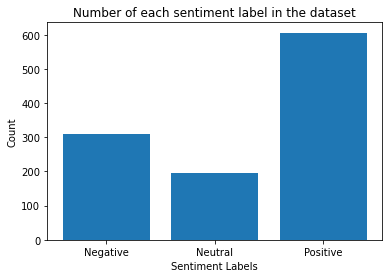

In [4]:
import matplotlib.pyplot as plt

label_counts = np.unique(all_labels, return_counts=True)
label_names = ["Negative", "Neutral", "Positive"]

plt.bar(label_names, label_counts[1])
plt.xlabel("Sentiment Labels")
plt.ylabel("Count")
plt.title("Number of each sentiment label in the dataset")
plt.show()


This bar chart allows me visualise the number of each sentiment label there are in the dataset

In [5]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels,
    random_state =42# make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels,
    random_state = 42# make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')

Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [6]:
print(f'What does one instance look like from the training set? \n\n{train_documents[0]}')
print(f'...and here is its corresponding label \n\n{train_labels[0]}')

What does one instance look like from the training set? 

ARM Royalties Accelerate as Smartphone Market Regains Strength
...and here is its corresponding label 

2


# Preprocessing steps:

In [8]:
import re
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer

# Tokenize and lemmatize
def preprocess_text(text):
    
    text = re.sub(r'http\S+|www\S+', '', text)
    
    result=[]
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 2:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return ' '.join(result)

# Apply preprocessing to the text data
train_documents = [preprocess_text(doc) for doc in train_documents]
val_documents = [preprocess_text(doc) for doc in val_documents]
test_documents = [preprocess_text(doc) for doc in test_documents]


In [9]:
# Choose an index
index = 220

# Print the original sentence
print("Original sentence:")
print(all_text[index])

# Preprocess the original sentence
preprocessed_sentence = preprocess_text(all_text[index])

# Print the preprocessed sentence
print("\nPreprocessed sentence:")
print(preprocessed_sentence)


Original sentence:
AB InBev approaches SABMiller to explore $250bn tie-up

Preprocessed sentence:
inbev approach sabmiller explore tie


# Fitting the pre-processed datasets to the Word2Vec model

In [10]:

from gensim.models import Word2Vec

# Convert preprocessed text data into list of word tokens
train_tokenized = [doc.split() for doc in train_documents]
val_tokenized = [doc.split() for doc in val_documents]
test_tokenized = [doc.split() for doc in test_documents]

# Train Word2Vec model on training data
w2v_model = Word2Vec(
    train_tokenized,
    sg = 1,
    window=5,  # context window size
    min_count=5,  # minimum word frequency threshold
    workers=4)  # number of worker threads for training

# Generate word embeddings for each token in the text data
train_vectors = []
for doc in train_tokenized:
    doc_vectors = []
    for token in doc:
        try:
            vector = w2v_model.wv[token]
            doc_vectors.append(vector)
        except KeyError:
            pass  # skip tokens not in the Word2Vec model
    train_vectors.append(doc_vectors)

# Combine the embeddings of all words in a document to generate a single vector representation for the document
train_document_vectors = []
for doc_vectors in train_vectors:
    if len(doc_vectors) > 0:
        doc_vector = np.mean(doc_vectors, axis=0)  # take the mean of all word vectors in the document
    else:
        doc_vector = np.zeros(w2v_model.vector_size)  # use a zero vector if the document is empty
    train_document_vectors.append(doc_vector)

# Repeat the same process for the validation and test data
val_vectors = []
for doc in val_tokenized:
    doc_vectors = []
    for token in doc:
        try:
            vector = w2v_model.wv[token]
            doc_vectors.append(vector)
        except KeyError:
            pass
    val_vectors.append(doc_vectors)

val_document_vectors = []
for doc_vectors in val_vectors:
    if len(doc_vectors) > 0:
        doc_vector = np.mean(doc_vectors, axis=0)
    else:
        doc_vector = np.zeros(w2v_model.vector_size)
    val_document_vectors.append(doc_vector)

test_vectors = []
for doc in test_tokenized:
    doc_vectors = []
    for token in doc:
        try:
            vector = w2v_model.wv[token]
            doc_vectors.append(vector)
        except KeyError:
            pass
    test_vectors.append(doc_vectors)

test_document_vectors = []
for doc_vectors in test_vectors:
    if len(doc_vectors) > 0:
        doc_vector = np.mean(doc_vectors, axis=0)
    else:
        doc_vector = np.zeros(w2v_model.vector_size)
    test_document_vectors.append(doc_vector)

#fitting the logistic regression model to the training set and using it as a baseline to compare to SVMs
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(train_document_vectors, train_labels)

#evaluating the model on the validation and test data
val_predictions = clf.predict(val_document_vectors)
test_predictions = clf.predict(test_document_vectors)



In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Calculate the evaluation metrics for the validation and test data
val_accuracy = accuracy_score(val_labels, val_predictions)
val_precision = precision_score(val_labels, val_predictions, average='macro')
val_recall = recall_score(val_labels, val_predictions, average='macro')
val_f1 = f1_score(val_labels, val_predictions, average='macro')

test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='macro')
test_recall = recall_score(test_labels, test_predictions, average='macro')
test_f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the evaluation metrics
print(f'Validation Accuracy: {val_accuracy:.3f}')
print(f'Validation Precision: {val_precision:.3f}')
print(f'Validation Recall: {val_recall:.3f}')
print(f'Validation F1 Score: {val_f1:.3f}')

print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Test Precision: {test_precision:.3f}')
print(f'Test Recall: {test_recall:.3f}')
print(f'Test F1 Score: {test_f1:.3f}')

print(classification_report(val_labels, val_predictions))
print(classification_report(test_labels, test_predictions))



Validation Accuracy: 0.545
Validation Precision: 0.182
Validation Recall: 0.333
Validation F1 Score: 0.235
Test Accuracy: 0.547
Test Precision: 0.182
Test Recall: 0.333
Test F1 Score: 0.236
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        24
           2       0.54      1.00      0.71        73

    accuracy                           0.54       134
   macro avg       0.18      0.33      0.24       134
weighted avg       0.30      0.54      0.38       134

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.00      0.00      0.00        39
           2       0.55      1.00      0.71       122

    accuracy                           0.55       223
   macro avg       0.18      0.33      0.24       223
weighted avg       0.30      0.55      0.39       223



/Users/thomascourts/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomascourts/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomascourts/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomascourts/opt/

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC

# Define the SVM model with default hyperparameters
svm_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear', random_state=42))
])

# Define the grid of hyperparameters to search over
param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__degree': [2, 3, 4]
}

# Perform grid search with cross-validation on the training data
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_documents, train_labels)

# Print the best hyperparameters found by grid search
print(f'Best hyperparameters: {grid_search.best_params_}')

# Evaluate the SVM model with the best hyperparameters on the validation and test data
val_predictions = grid_search.predict(val_documents)
test_predictions = grid_search.predict(test_documents)

# Calculate the evaluation metrics for the validation and test data
val_accuracy = accuracy_score(val_labels, val_predictions)
val_precision = precision_score(val_labels, val_predictions, average='macro')
val_recall = recall_score(val_labels, val_predictions, average='macro')
val_f1 = f1_score(val_labels, val_predictions, average='macro')

test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='macro')
test_recall = recall_score(test_labels, test_predictions, average='macro')
test_f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the evaluation metrics with the best hyperparameters
print(f'Validation Accuracy: {val_accuracy:.3f}')
print(f'Validation Precision: {val_precision:.3f}')
print(f'Validation Recall: {val_recall:.3f}')
print(f'Validation F1 Score: {val_f1:.3f}')

print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Test Precision: {test_precision:.3f}')
print(f'Test Recall: {test_recall:.3f}')
print(f'Test F1 Score: {test_f1:.3f}')

print(classification_report(val_labels, val_predictions))
print(classification_report(test_labels, test_predictions))




Best hyperparameters: {'clf__C': 1, 'clf__degree': 2, 'clf__kernel': 'linear'}
Validation Accuracy: 0.709
Validation Precision: 0.688
Validation Recall: 0.582
Validation F1 Score: 0.591
Test Accuracy: 0.641
Test Precision: 0.608
Test Recall: 0.497
Test F1 Score: 0.503
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        37
           1       0.57      0.17      0.26        24
           2       0.69      0.90      0.78        73

    accuracy                           0.71       134
   macro avg       0.69      0.58      0.59       134
weighted avg       0.70      0.71      0.67       134

              precision    recall  f1-score   support

           0       0.63      0.44      0.51        62
           1       0.55      0.15      0.24        39
           2       0.65      0.90      0.76       122

    accuracy                           0.64       223
   macro avg       0.61      0.50      0.50       223
weighted avg       0.63 

In [13]:
# Compare predicted and true labels to find misclassified instances
misclassified_indices = []
for i in range(len(val_labels)):
    if val_labels[i] != val_predictions[i]:
        misclassified_indices.append(i)

# Print out a few misclassified instances
for i in range(min(len(misclassified_indices), 10)):
    index = misclassified_indices[i]
    print('Sentence:', val_documents[index])
    print('True label:', val_labels[index])
    print('Predicted label:', val_predictions[index])
    print('-'*50)


Sentence: twtr best scenario go forward stock slowly fall everyday probable
True label: 0
Predicted label: 2
--------------------------------------------------
Sentence: bxs bancorpsouth announce extension merger agreements
True label: 2
Predicted label: 1
--------------------------------------------------
Sentence: petrofac share price rise despite cost north sea project
True label: 1
Predicted label: 2
--------------------------------------------------
Sentence: update shareholders disclosure climate change risk
True label: 1
Predicted label: 2
--------------------------------------------------
Sentence: aapl break descend channel hold
True label: 1
Predicted label: 2
--------------------------------------------------
Sentence: academics claim google android factor authentication breakable security authentication hack goog
True label: 0
Predicted label: 2
--------------------------------------------------
Sentence: aapl new long break target bear retake qqq nq_f ndx
True label: 1
Pre

In [14]:
negative_docs = [doc for doc, label in zip(train_documents, train_labels) if label == 0]
positive_docs = [doc for doc, label in zip(train_documents, train_labels) if label == 2]


In [15]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

def prepare_lda_data(docs):
    # Tokenize the documents
    tokenized_docs = [doc.split() for doc in docs]

    # Create a dictionary and a corpus
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    return dictionary, corpus


In [16]:
negative_dictionary, negative_corpus = prepare_lda_data(negative_docs)
positive_dictionary, positive_corpus = prepare_lda_data(positive_docs)

print(negative_dictionary)

Dictionary(878 unique tokens: ['breach', 'change', 'claim', 'competition', 'delivery']...)


In [17]:
#setting the number of topics for the lda model
num_topics = 10

negative_lda = LdaModel(negative_corpus, num_topics=num_topics, id2word=negative_dictionary, passes=10, random_state=42)
positive_lda = LdaModel(positive_corpus, num_topics=num_topics, id2word=positive_dictionary, passes=10, random_state=42)


In [18]:
def print_topics(lda_model, num_topics, num_words=10):
    for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=num_words):
        print(f'Topic {idx}: {topic}\n')

print("Negative topics:")
print_topics(negative_lda, num_topics)

print("Positive topics:")
print_topics(positive_lda, num_topics)


Negative topics:
Topic 0: 0.021*"price" + 0.021*"short" + 0.013*"share" + 0.013*"sue" + 0.009*"close" + 0.009*"drop" + 0.009*"resistance" + 0.009*"retest" + 0.009*"windows" + 0.009*"ntap"

Topic 1: 0.018*"bearish" + 0.014*"look" + 0.009*"aapl" + 0.009*"share" + 0.009*"weak" + 0.009*"buy" + 0.009*"million" + 0.009*"xlf" + 0.009*"good" + 0.009*"pattern"

Topic 2: 0.027*"short" + 0.008*"fall" + 0.008*"cost" + 0.008*"lower" + 0.008*"move" + 0.008*"energy" + 0.008*"rbs" + 0.008*"hit" + 0.008*"follow" + 0.008*"low"

Topic 3: 0.048*"tsla" + 0.042*"recall" + 0.036*"model" + 0.028*"tesla" + 0.019*"rat" + 0.015*"sell" + 0.013*"lower" + 0.013*"aapl" + 0.012*"cars" + 0.010*"spy"

Topic 4: 0.012*"sell" + 0.012*"price" + 0.012*"share" + 0.012*"support" + 0.008*"spy" + 0.008*"dma" + 0.008*"year" + 0.008*"signal" + 0.008*"lower" + 0.008*"red"

Topic 5: 0.019*"short" + 0.015*"market" + 0.010*"sell" + 0.010*"get" + 0.010*"aapl" + 0.010*"iwm" + 0.010*"chart" + 0.010*"think" + 0.010*"boat" + 0.010*"pretty

In [19]:
#importing modules to display my results
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display



In [20]:
def visualize_lda(lda_model, corpus, dictionary):
    vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
    display(pyLDAvis.display(vis_data))


In [21]:
#visualising the results of my topics
print("Negative sentiment topics:")
visualize_lda(negative_lda, negative_corpus, negative_dictionary)

print("Positive sentiment topics:")
visualize_lda(positive_lda, positive_corpus, positive_dictionary)


Negative sentiment topics:


Positive sentiment topics:


In [22]:
#creating a function to print out keywords in the different sentiment topics
def get_topic_keywords(lda_model, num_keywords=5):
    topic_keywords = {}
    for topic_id, topic in lda_model.show_topics(formatted=False, num_topics=-1, num_words=num_keywords):
        keywords = [word for word, _ in topic]
        topic_keywords[topic_id] = keywords
    return topic_keywords

negative_topic_keywords = get_topic_keywords(negative_lda)
positive_topic_keywords = get_topic_keywords(positive_lda)

print("Negative sentiment topic keywords:")
for topic_id, keywords in negative_topic_keywords.items():
    print(f"Topic {topic_id + 1}: {', '.join(keywords)}")

print("\nPositive sentiment topic keywords:")
for topic_id, keywords in positive_topic_keywords.items():
    print(f"Topic {topic_id + 1}: {', '.join(keywords)}")


Negative sentiment topic keywords:
Topic 1: price, short, share, sue, close
Topic 2: bearish, look, aapl, share, weak
Topic 3: short, fall, cost, lower, move
Topic 4: tsla, recall, model, tesla, rat
Topic 5: sell, price, share, support, spy
Topic 6: short, market, sell, get, aapl
Topic 7: sbux, downgrade, day, share, starbucks
Topic 8: look, like, share, chart, quarter
Topic 9: short, oil, fall, tesco, price
Topic 10: spy, aapl, break, price, share

Positive sentiment topic keywords:
Topic 1: long, dividend, share, company, plc
Topic 2: aapl, call, sabmiller, inbev, boost
Topic 3: buy, new, higher, close, add
Topic 4: nice, aapl, higher, low, buy
Topic 5: buy, week, high, share, rat
Topic 6: plc, buy, sales, group, tesco
Topic 7: deal, astrazeneca, drug, update, bid
Topic 8: long, market, short, breakout, sell
Topic 9: long, aapl, break, buy, look
Topic 10: rise, look, bye, sales, like


In [23]:
from gensim.corpora import Dictionary

# Tokenize preprocessed text
tokenized_docs = [doc.split() for doc in train_documents]

# Create dictionary
dictionary = Dictionary(tokenized_docs)
print(dictionary)

# Create bag of words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]


Dictionary(2167 unique tokens: ['accelerate', 'arm', 'market', 'regain', 'royalties']...)


In [24]:
#fitting the LDAModel
from gensim.models import LdaModel

lda_model =  LdaModel(bow_corpus, 
                      num_topics=20, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

In [25]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.016*"buy" + 0.013*"price" + 0.011*"trade" + 0.011*"upside" + 0.010*"consolidation" + 0.010*"share" + 0.008*"plc" + 0.008*"yesterday" + 0.008*"royal" + 0.008*"long"


Topic: 1 
Words: 0.015*"close" + 0.015*"astrazeneca" + 0.011*"buy" + 0.010*"new" + 0.009*"drug" + 0.008*"hod" + 0.008*"billion" + 0.007*"year" + 0.007*"day" + 0.007*"breakout"


Topic: 2 
Words: 0.014*"sell" + 0.011*"profit" + 0.009*"share" + 0.009*"position" + 0.009*"tesco" + 0.009*"break" + 0.009*"hit" + 0.009*"market" + 0.006*"company" + 0.006*"alert"


Topic: 3 
Words: 0.030*"aapl" + 0.022*"spy" + 0.018*"sell" + 0.016*"ftse" + 0.012*"share" + 0.011*"tesco" + 0.010*"sales" + 0.010*"rat" + 0.010*"lead" + 0.009*"new"


Topic: 4 
Words: 0.022*"aapl" + 0.015*"share" + 0.013*"resistance" + 0.013*"look" + 0.012*"price" + 0.010*"short" + 0.009*"bhp" + 0.008*"year" + 0.008*"lower" + 0.008*"support"


Topic: 5 
Words: 0.016*"long" + 0.015*"short" + 0.012*"billion" + 0.012*"deal" + 0.012*"gain" + 0.012*"call" +

In [26]:
test_document_idx = 112
unseen_document = test_documents[test_document_idx]
print(unseen_document)

# Data preprocessing step for the unseen document
preprocessed_doc = preprocess_text(unseen_document)
bow_vector = dictionary.doc2bow(preprocessed_doc.split())

for idx, count in bow_vector:
    print(f'{dictionary[idx]}: {count}')


tsla wish put support pop
support: 1
tsla: 1
pop: 1


In [27]:
topic_distribution = lda_model[bow_vector]

for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model.print_topic(index, 5)))

Index: 0
Probability: 0.26683318614959717	 Topic: 0.016*"buy" + 0.013*"price" + 0.011*"trade" + 0.011*"upside" + 0.010*"consolidation"
Index: 11
Probability: 0.2624928057193756	 Topic: 0.020*"buy" + 0.017*"good" + 0.014*"today" + 0.011*"week" + 0.010*"break"
Index: 16
Probability: 0.2581636607646942	 Topic: 0.045*"tsla" + 0.035*"recall" + 0.025*"model" + 0.021*"tesla" + 0.018*"short"
Index: 1
Probability: 0.012500609271228313	 Topic: 0.015*"close" + 0.015*"astrazeneca" + 0.011*"buy" + 0.010*"new" + 0.009*"drug"
Index: 2
Probability: 0.012500609271228313	 Topic: 0.014*"sell" + 0.011*"profit" + 0.009*"share" + 0.009*"position" + 0.009*"tesco"
Index: 3
Probability: 0.012500609271228313	 Topic: 0.030*"aapl" + 0.022*"spy" + 0.018*"sell" + 0.016*"ftse" + 0.012*"share"
Index: 4
Probability: 0.012500609271228313	 Topic: 0.022*"aapl" + 0.015*"share" + 0.013*"resistance" + 0.013*"look" + 0.012*"price"
Index: 5
Probability: 0.012500609271228313	 Topic: 0.016*"long" + 0.015*"short" + 0.012*"billio

In [28]:
def get_sample_documents(num_docs, documents):
    doc_idxs = np.random.choice(len(documents), num_docs, replace=False)
    return doc_idxs

def get_topic_dists_in_sample_documents(lda_model, documents, num_docs=10):
    doc_idxs = get_sample_documents(num_docs, documents)

    # Save each topic distribution to the list 'thetas'
    thetas = []

    for doc_idx in doc_idxs:
        # Get the document
        unseen_document = documents[doc_idx]

        # Apply preprocessing to get a bag-of-words vector
        bow_vector = dictionary.doc2bow(preprocess(unseen_document))

        # Use the LDA model to compute the topic distribution for this document
        theta_d = lda_model[bow_vector]

        thetas.append(theta_d)

    return thetas




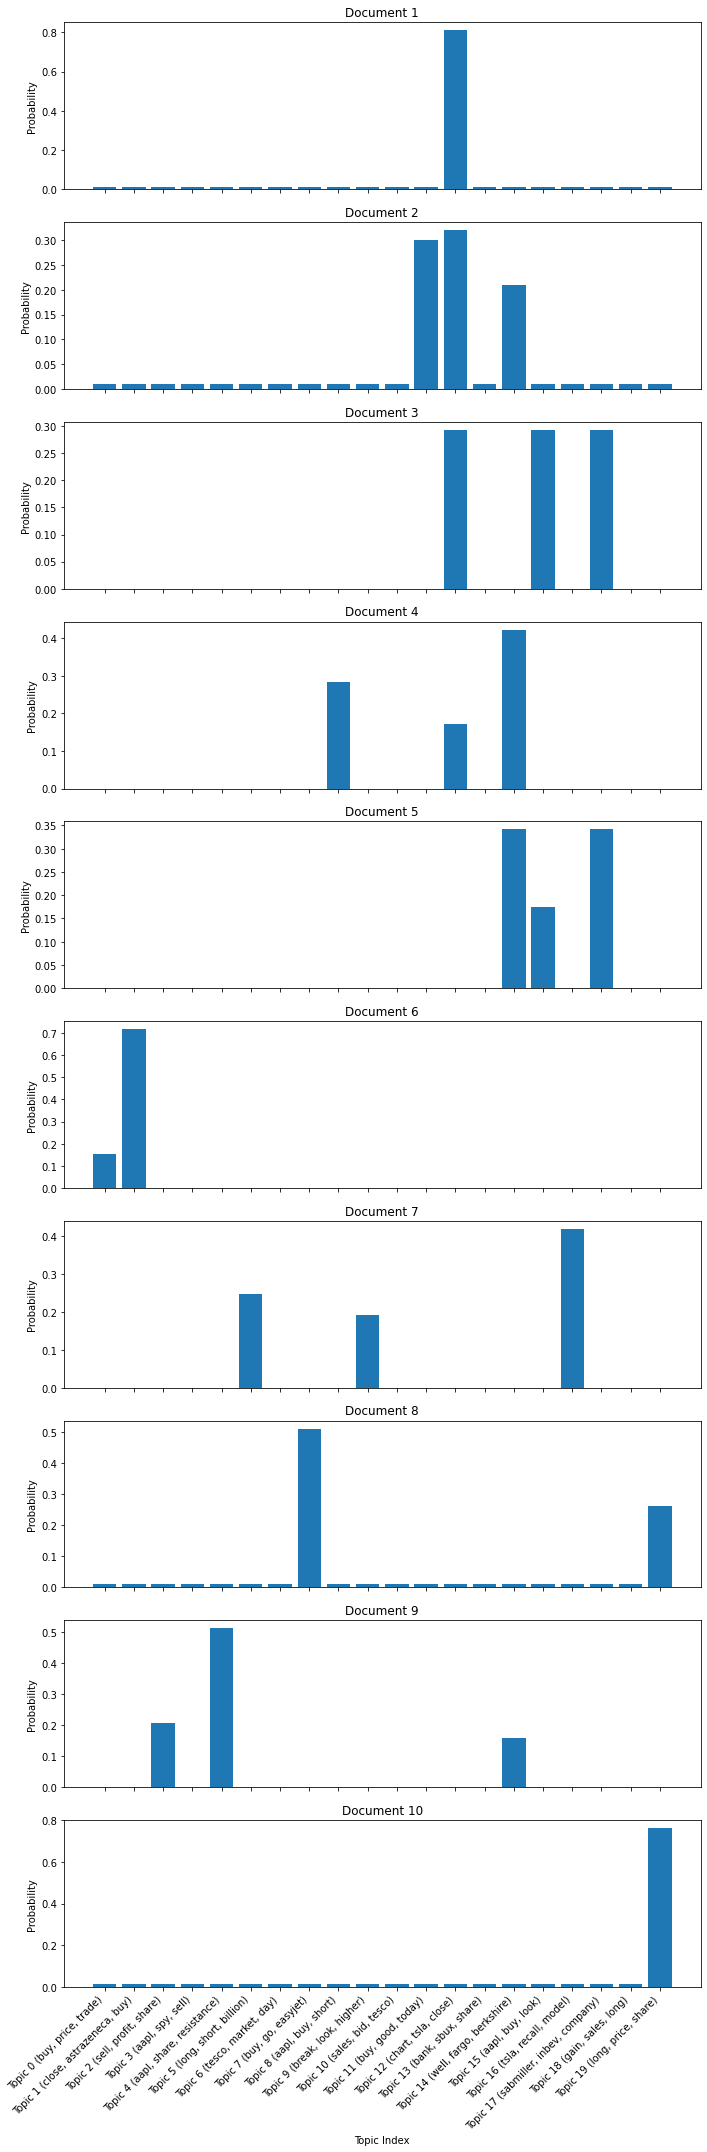

In [29]:
import matplotlib.pyplot as plt

def get_topic_distributions(documents, lda_model, dictionary, preprocess_text):
    topic_distributions = []

    for document in documents:
        preprocessed_doc = preprocess_text(document)
        bow_vector = dictionary.doc2bow(preprocessed_doc.split())
        topic_distribution = lda_model[bow_vector]
        topic_distributions.append(topic_distribution)

    return topic_distributions

import numpy as np

def visualize_topic_distributions(topic_distributions, lda_model, num_topics):
    fig, axes = plt.subplots(len(topic_distributions), 1, figsize=(10, len(topic_distributions) * 3), sharex=True)

    #preparing topic labels using the top 3 words from each topic
    topic_labels = []
    for i in range(num_topics):
        words = [t[0] for t in lda_model.show_topic(i, topn=3)]
        topic_labels.append(f'Topic {i} ({", ".join(words)})')

    for i, topic_distribution in enumerate(topic_distributions):
        topic_probs = [0] * num_topics
        for index, probability in topic_distribution:
            topic_probs[index] = probability

        axes[i].bar(range(num_topics), topic_probs, tick_label=topic_labels)
        axes[i].set_title(f'Document {i + 1}')
        axes[i].set_ylabel('Probability')

    plt.xlabel('Topic Index')
    plt.xticks(range(num_topics), topic_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    

documents_to_visualize = test_documents[:10]
num_topics = 20 

#using the same documents_to_visualize and num_topics as before
topic_distributions = get_topic_distributions(documents_to_visualize, lda_model, dictionary, preprocess_text)
visualize_topic_distributions(topic_distributions, lda_model, num_topics)

